# Title: Carbon Emissions Observations
By: Laura Suchomska, Ravi Malde, Augustin Goudet

# I. Package Install Installation

In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")

# II. Data Collection - CIA WorldFactbook

In [2]:
#Collating all the potential sources of data from the CIA WorldFactbook

files = ['AIRPORTS',
'AREA',
'BUDGET',
'continent',
'CURACCT',
'DEBTFOREIGNERS',
'EDUCATIONSPEND',
'electricconsupmtion',
'emissions',
'EXPORTS',
'fossilelectricity',
'GDP',
'GDPGROWTH',
'GDPPERCAP',
'hydroelectricity',
'IMPORTS',
'INDUSTPRODGR',
'internetusers',
'LIFEXP',
'MARMERCHANT',
'MIGRATION',
'MILIEXPENDITURE',
'naturalgasconsumption',
'nuclearelectricity',
'otherrenewableelectricity',
'petroleumconsumption',
'POPGROWTH',
'POPULATION',
'PUBLICDEBT',
'RAILWAYS',
'ROADWAYS',
'UNEMPLOYMENT',
'WATERWAYS',
'WORKFORCE']

In [3]:
#storing all the csv in a dictionary

pd_dict = {}
for file in files:
    pd_dict[file] = pd.read_csv('{}.csv'.format(file))

In [4]:
#Creating the dataframes from the dictionary

base_df = pd_dict['continent']
area_df = pd_dict['AREA']
petrol_df = pd_dict['petroleumconsumption']
users_df = pd_dict['internetusers']
hydro_df = pd_dict['hydroelectricity']
nuclear_df = pd_dict['nuclearelectricity']
otherrenew_df = pd_dict['otherrenewableelectricity']
mili_df = pd_dict['MILIEXPENDITURE']
co2_df = pd_dict['emissions']
pop_df = pd_dict['POPULATION']

# III. Data Transformation 

In [5]:
#Standardization of country names to merge
for i, row in base_df.iterrows():
    row['country_name'] = row['country_name'].split(",")
    row ['country_name'] = row['country_name'][0]

In [11]:
#Renaming columns to facilitate merge
mili_df.rename(columns = {"% OF GDP": "mili_exp_gdp"}, inplace = True)
base_df.rename(columns = {'country_name':'Country'}, inplace = True)


In [12]:
#Merging base dataframe to bring in continent_name and country fields together
base_df.merge(area_df, on = 'Country', how = 'left')
base_df.head(n=1)

,continent_name,Country
0,Asia,Afghanistan


In [13]:
#Merging relevant country attributes to create a single dataframe to work on

df1 = base_df.merge(area_df, on = 'Country', how = 'left')
df1.rename(columns = {'Country':'country'}, inplace = True)
df2 = df1.merge(petrol_df, on = 'country', how = 'outer')
df3 = df2.merge(users_df, on = 'country', how = 'outer')
df4 = df3.merge(hydro_df, on = 'country', how = 'outer')
df5 = df4.merge(nuclear_df, on = 'country', how = 'outer')
df6 = df5.merge(otherrenew_df, on = 'country', how = 'outer')
mili_df.rename(columns = {'COUNTRY':'country'}, inplace = True)
df7 = df6.merge(mili_df, on = 'country', how = 'outer')
df8 = df7.merge(co2_df, on = 'country', how = 'outer')
pop_df.rename(columns = {'Country':'country'}, inplace = True)
df9 = df8.merge(pop_df, on = 'country', how = 'outer')
df9.head(n=2)


,continent_name,country,Index_x,Area_sqKm,Unnamed: 0_x,refined_petroleum_consumption_barrels_per_day,year_x,Unnamed: 4_x,Unnamed: 0_y,number_of_internet_users,...,Unnamed: 4_x,Unnamed: 0,year,carbon_emissions_from_energy_consumption_MT,Unnamed: 4_y,Index_y,Population,Month,Year,Unnamed: 5
0,Asia,Afghanistan,42.0,"652,230.00",117.0,"35,000",2016.0,est.,NaN,NaN,...,NaN,111.0,2017.0,"9,067,000.00",est.,39.0,"36,643,815",July,2020,est.
1,Europe,Albania,145.0,"28,748.00",120.0,"29,000",2016.0,est.,111.0,"2,016,516",...,est.,136.0,2017.0,"4,500,000.00",est.,136.0,"3,074,579",July,2020,est.


In [16]:
#Creating our main DataFrame with relevant country attributes

final_df = df9[['continent_name','country','Area_sqKm','refined_petroleum_consumption_barrels_per_day','number_of_internet_users', 'hydro_percentage_of_electricity_production','nuclear_percentage_of_electricity_production', 'other_renewable_percentage_of_electricity_production',"mili_exp_gdp","carbon_emissions_from_energy_consumption_MT","Population"]].copy()
final_df.sample(n=2)

,continent_name,country,Area_sqKm,refined_petroleum_consumption_barrels_per_day,number_of_internet_users,hydro_percentage_of_electricity_production,nuclear_percentage_of_electricity_production,other_renewable_percentage_of_electricity_production,mili_exp_gdp,carbon_emissions_from_energy_consumption_MT,Population
169,Oceania,Micronesia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,Europe,Denmark,"43,094.00","158,500","5,424,169",0.0,0.0,54.0,1.32,"37,450,000.00","5,869,410"


In [17]:
#Checking for data point format / change objects to floats for numerical variables
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283 entries, 0 to 282
Data columns (total 11 columns):
continent_name                                          257 non-null object
country                                                 283 non-null object
Area_sqKm                                               222 non-null object
refined_petroleum_consumption_barrels_per_day           221 non-null object
number_of_internet_users                                232 non-null object
hydro_percentage_of_electricity_production              221 non-null float64
nuclear_percentage_of_electricity_production            221 non-null float64
other_renewable_percentage_of_electricity_production    220 non-null float64
mili_exp_gdp                                            164 non-null float64
carbon_emissions_from_energy_consumption_MT             220 non-null object
Population                                              244 non-null object
dtypes: float64(4), object(7)
memory usage: 26.5+ KB


In [35]:
# Removing commas from numbers to transform objects into floats

final_df['Area_sqKm'] = final_df['Area_sqKm'].str.replace(',', '')
final_df['refined_petroleum_consumption_barrels_per_day'] = final_df['refined_petroleum_consumption_barrels_per_day'].str.replace(',', '')
final_df['number_of_internet_users'] = final_df['number_of_internet_users'].str.replace(',', '')
final_df['carbon_emissions_from_energy_consumption_MT'] = final_df['carbon_emissions_from_energy_consumption_MT'].str.replace(',', '')


In [38]:
#Conversion of objects to floats

final_df['Area_sqKm'] = final_df['Area_sqKm'].astype(float)
final_df['refined_petroleum_consumption_barrels_per_day'] = final_df['refined_petroleum_consumption_barrels_per_day'].astype(float)
final_df['number_of_internet_users'] = final_df['number_of_internet_users'].astype(float)
final_df['carbon_emissions_from_energy_consumption_MT'] = final_df['carbon_emissions_from_energy_consumption_MT'].astype(float)



# IV. Null Values Treatment

In [40]:
#Checking for null values

final_df.isnull().sum()

In [42]:
#Treatment for null values - dropping erroneous names / Nan Area points
final_df.dropna(subset=['continent_name', "Area_sqKm", "refined_petroleum_consumption_barrels_per_day"], inplace = True)


In [53]:
#Treatment for null values - adding mili expenditures median for two countries / fill with 0 for remainder

median_exp = final_df['mili_exp_gdp'].median()
armed_countries = ['Syria','Qatar']

rows_to_change = list(final_df[(final_df['mili_exp_gdp'].isnull()) &
         (final_df.country.isin(armed_countries))].index)

final_df.loc[rows_to_change,'mili_exp_gdp'] = median_exp
final_df[final_df.country.isin(armed_countries)]

final_df['mili_exp_gdp'].fillna(0,inplace = True )

In [54]:
##Treatment for null values - adding internet users median for two countries / fill with 0 for remainder

median_int = final_df['number_of_internet_users'].median()
internet_users = ['Afghanistan','South Sudan']

int_rows_to_change = list(final_df[(final_df['number_of_internet_users'].isnull()) &
         (final_df.country.isin(internet_users))].index)

final_df.loc[int_rows_to_change,'number_of_internet_users'] = median_int
final_df[final_df.country.isin(internet_users)]

final_df['number_of_internet_users'].fillna(0,inplace = True )

final_df.isnull().sum()

continent_name                                          0
country                                                 0
Area_sqKm                                               0
refined_petroleum_consumption_barrels_per_day           0
number_of_internet_users                                0
hydro_percentage_of_electricity_production              0
nuclear_percentage_of_electricity_production            0
other_renewable_percentage_of_electricity_production    0
mili_exp_gdp                                            0
carbon_emissions_from_energy_consumption_MT             0
Population                                              0
mili_exp_%_gdp                                          0
dtype: int64

# VI. Exploratory Data Analysis

In [56]:
#Crombining non-fossil electricity fields / proxy for renewable source

final_df['non_fossil_electricity'] = final_df['hydro_percentage_of_electricity_production'] + final_df['nuclear_percentage_of_electricity_production'] + final_df['other_renewable_percentage_of_electricity_production']


In [66]:
#Creating a continent view to get mean values per continent

continent_df = final_df.pivot_table(index = 'continent_name', values = ['refined_petroleum_consumption_barrels_per_day', 
                                                         'number_of_internet_users','non_fossil_electricity' 
                                                         ,'carbon_emissions_from_energy_consumption_MT',"mili_exp_gdp"], aggfunc = np.mean)



continent_df.reset_index(inplace = True)

#Styling DataFrame using styler

continent_df['mili_exp_gdp'] = continent_df['mili_exp_gdp'].div(100).round(4)
continent_df['non_fossil_electricity'] = continent_df['non_fossil_electricity'].div(100).round(4)


cdf = continent_df.style.format({'continent_name': str.upper,
                           'carbon_emissions_from_energy_consumption_MT': '{:20,.0f}',"mili_exp_gdp":'{:.2%}',
                          "number_of_internet_users":'{:20,.0f}', "refined_petroleum_consumption_barrels_per_day":'{:20,.0f}',"non_fossil_electricity":'{:.2%}'})

cdf

,continent_name,carbon_emissions_from_energy_consumption_MT,mili_exp_gdp,non_fossil_electricity,number_of_internet_users,refined_petroleum_consumption_barrels_per_day
0,AFRICA,"27,374,741",1.43%,37.33%,"5,868,278","77,448"
1,ASIA,"466,522,251",2.50%,27.96%,"39,905,819","873,358"
2,EUROPE,"145,304,857",1.55%,49.60%,"13,921,629","415,173"
3,NORTH AMERICA,"211,292,993",0.52%,24.23%,"12,467,495","820,406"
4,OCEANIA,"29,204,432",0.25%,27.59%,"1,538,164","85,270"
5,SOUTH AMERICA,"96,821,667",1.49%,51.42%,"20,381,686","485,792"


# VII. Evaluating Residual Distribution

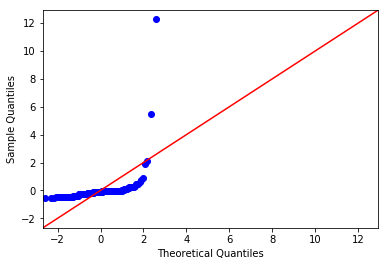

In [85]:
co2_model = ols("carbon_emissions_from_energy_consumption_MT ~ C(continent_name)", data=final_df).fit()
residuals = co2_model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

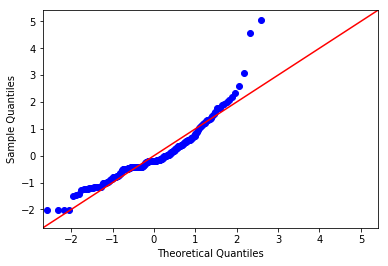

In [92]:
mili_model = ols("mili_exp_gdp ~ C(continent_name)", data=final_df).fit()
residuals = mili_model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

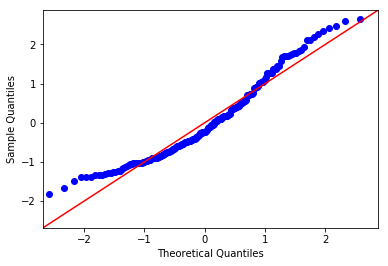

In [93]:
ele_model = ols("non_fossil_electricity ~ C(continent_name)", data=final_df).fit()
residuals = ele_model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

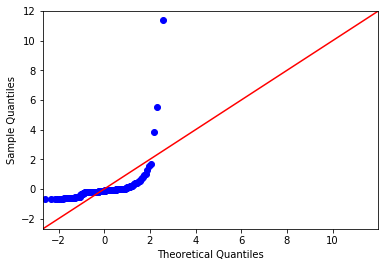

In [94]:
int_model = ols("number_of_internet_users ~ C(continent_name)", data=final_df).fit()
residuals = int_model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()

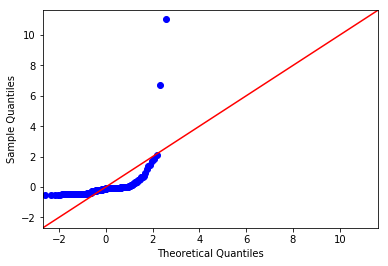

In [95]:
petrol_model = ols("refined_petroleum_consumption_barrels_per_day ~ C(continent_name)", data=final_df).fit()
residuals = petrol_model.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
fig.show()